<a href="https://colab.research.google.com/github/arpanbiswas52/PLsyn_BO/blob/main/AE_PLDsysn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Experiments of PLD synthesis through BO

- Problem domain expert/ Experimental Set up - Sumner Haris
- BO modeling -- Arpan Biswas

#Problem Description

Build a BO framework-

- Here we have an experimental set up of $WSE_2$ monolayer flims grown by PLD. 

- We want to optimize the control parameters for best experimental results.

- The goal is to do an automated experiment set up through BO model- where we sequnetially learn and adaptively sample towards region of best experimental outcome (synthesis).

- In this notebook, we build the framework of BO to connect with the experiments

In [2]:
!pip install botorch #version 0.5.1
!pip install gpytorch #version 1.6.0
!pip install smt
!pip install lmfit
#!pip install WSe2_Target_Extractor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 387 kB 5.2 MB/s 
     |████████████████████████████████| 361 kB 57.2 MB/s 
     |████████████████████████████████| 722 kB 60.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for smt: filename=smt-1.3.0-cp37-cp37m-linux_x86_64.whl size=528038 sha256=051617ee3004723affedcb48d61f96a2b54ace4c494e07c842ef96cda7301e3c
  Stored in directory: /root/.cache/pip/wheels/e1/5b/7b/a60bcc2b0411788df670d0059b80599c9644e922dab40a6bc4
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25539 sha256

In [3]:
#@title Imports
import torch
import pandas as pd
from torchvision import datasets, transforms
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from skimage.transform import resize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Import GP and BoTorch functions
import gpytorch as gpt
from botorch.models import SingleTaskGP, ModelListGP
#from botorch.models import gpytorch
from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel, PiecewisePolynomialKernel, PeriodicKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import IIDNormalSampler
from botorch.sampling import SobolQMCNormalSampler
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from botorch.generation import get_best_candidates, gen_candidates_torch
from botorch.optim import gen_batch_initial_conditions
from gpytorch.models import ExactGP

## For Ramam data fit 
from scipy.signal import medfilt
from lmfit.models import LorentzianModel, PolynomialModel

from smt.sampling_methods import LHS
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm
from scipy.signal import find_peaks, peak_prominences



In [4]:
#@title objective function evaluation- maximize peak2_prominance/peak2_FWHM
def lamb2shift(lamb,ex):
    shift = 1e7/ex - 1e7/lamb
    return shift

def SNV(I_data):
    mean = I_data.mean()
    std = I_data.std()
    
    return (I_data-mean)/std

def MinMax(I_data):
    mn = I_data.min()
    mx = I_data.max()
    
    return (I_data-mn)/(mx-mn)

def Despike_Norm(I_data):
    despiked = medfilt(I_data, kernel_size=7)
    return MinMax(despiked)

def get_WSe2_A1_FWHM_Si_ref_Raman(sample_file, reference_file,visualize=False):
    excitation_wavelength = 532.11
    # Get Raman spectrum from sample file, crop, despike, and normalize.
    #ram_data = pd.read_csv(sample_file)
    ram_data = sample_file
    w0, I0 = ram_data['Wavelength'], ram_data['Intensity']
    w, I = lamb2shift(w0,excitation_wavelength), I0
    bounds = (w>=70)&(w<=700)
    sub_x, sub_y = w[bounds], Despike_Norm(I[bounds])
    
    #This is the cropped, despiked, and normalized Raman data
    xdat, ydat = sub_x, sub_y
    
    # Crop, despike, and normalize the reference Si spectrum
    #ref_df = pd.read_csv(reference_file)
    ref_df = reference_file
    w0ref, I0ref = ref_df['Wavelength'], ref_df['Intensity']
    w, I = lamb2shift(w0ref,excitation_wavelength), I0ref
    sub_x, sub_y = w[bounds], I[bounds]
    
    #This is the cropped, despiked and normalized Si substrate spectrum
    subtrate_x, substrate_y = sub_x, Despike_Norm(sub_y)
    
    # Substrate subtracted data
    I_substrate_subtracted = ydat-substrate_y
    
    # Create the Raman spectrum multi Lorentzian model
    model = PolynomialModel(1, prefix='bkg_',nan_policy='omit')
    params = model.make_params(c0=0,c1=0)
    
    def add_peak(prefix, center, amplitude=1, sigma=10):
        peak = LorentzianModel(prefix=prefix)
        pars = peak.make_params()
        pars[prefix + 'center'].set(center,min=center-10,max=center+10)
        pars[prefix + 'amplitude'].set(amplitude,min=0)
        pars[prefix + 'sigma'].set(sigma,min=2.5,max=40)            
        return peak, pars

    rough_peak_positions = [117.4,230.1,247.3,364]#[LA2M_guess[i],351]
    for j, cen in enumerate(rough_peak_positions):
        peak, pars = add_peak('peak_%d_' % (j), cen)
        model = model + peak
        params.update(pars)   
    
    # Fit the model
    init = model.eval(params, x=xdat)
    result = model.fit(I_substrate_subtracted, params, x=xdat, max_nfev = 1000)
    comps = result.eval_components()
    
    if result.params['peak_2_fwhm'].stderr == None:
        print('This is probably a bad fit, check and retry')
        
    if visualize:
        plt.plot(xdat, I_substrate_subtracted, label='data')
        #plt.plot(xdat, result.best_fit, label='best fit')
        for name, comp in comps.items():
            if name != 'bkg_':
                plt.plot(xdat, comp+comps['bkg_'], '--', label=name)
                #print(np.max(comp+comps['bkg_']))
                #plt.plot(xdat, comp, '--', label=name)
            else:
                plt.plot(xdat,comp,'--',label=name)
        plt.legend()
        plt.show()
                
    return result, xdat

def func_obj(X, data):
    
    # Sumner will connect to his experimental set up
    # Pass params to experiments

    # Experiments run backend and pass the output (Raman, PL etc)
    sample_file = data[0]
    reference_file = data[1]

    # To fit Statistical Ramam fit 
    result, xdat = get_WSe2_A1_FWHM_Si_ref_Raman(sample_file, reference_file,visualize=True)
    fwhm = result.params['peak_2_fwhm'].value

    comps = result.eval_components()
    p_mat= comps['peak_2_']+comps['bkg_']
    slope_p = np.zeros((len(p_mat)-1))
    for i in range(0, len(p_mat)-1):
        p1 = p_mat[i]
        p2 = p_mat[i+1]
        slope_p[i]= np.absolute(p1-p2)

    pks, pks_ht = find_peaks(slope_p, height=1*max(slope_p))
    peak_prom = peak_prominences(slope_p, pks)[0]
    
    obj = (peak_prom*10e4)/fwhm  #To maximize
    obj = torch.from_numpy(obj)
    return obj

Below section defines the list of functions (user calls these functions during analysis):
1. Gaussian Process
2. Optimimize Hyperparameter of Gaussian Process (using Adam optimizer)
3. Posterior means and variance computation
4. Acquistion functions for BO- Expected Improvmement

In [108]:
class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        #self.mean_module = LinearMean(train_X.shape[-1])
        self.covar_module = ScaleKernel(
            #base_kernel=MaternKernel(nu=0.5, ard_num_dims=train_X.shape[-1]),
            #base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
            base_kernel=PeriodicKernel(ard_num_dims=train_X.shape[-1])
            #base_kernel = PiecewisePolynomialKernel(power = 2, ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

#Optimize Hyperparameters of GP#
def optimize_hyperparam_trainGP(train_X, train_Y):
    # Gp model fit

    gp_surro = SimpleCustomGP(train_X, train_Y)
    gp_surro = gp_surro.double()
    gp_surro.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    mll1 = ExactMarginalLogLikelihood(gp_surro.likelihood, gp_surro)
    # fit_gpytorch_model(mll)
    mll1 = mll1.to(train_X)
    gp_surro.train()
    gp_surro.likelihood.train()
    ## Here we use Adam optimizer with learning rate =0.1, user can change here with different algorithm and/or learning rate for each GP
    optimizer1 = Adam([{'params': gp_surro.parameters()}], lr=0.1)
    #optimizer1 = SGD([{'params': gp_surro.parameters()}], lr=0.0001)

    NUM_EPOCHS = 150

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer1.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output1 = gp_surro(train_X)
        # Compute negative marginal log likelihood
        loss1 = - mll1(output1, gp_surro.train_targets)
        # back prop gradients
        loss1.backward(retain_graph=True)
        # print last iterations
        if (epoch + 1) > NUM_EPOCHS: #Stopping the print for now
            print("GP Model trained:")
            print("Iteration:" + str(epoch + 1))
            print("Loss:" + str(loss1.item()))
            # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
            print("noise:" + str(gp_surro.likelihood.noise.item()))


        optimizer1.step()

    gp_surro.eval()
    gp_surro.likelihood.eval()
    return gp_surro


#GP posterior predictions#
def cal_posterior(gp_surro, test_X, X, norm=False):

    X1, X2, X3, X4 = X[0], X[1], X[2], X[3]
    X1, X2, X3, X4 = torch.meshgrid(X1, X2, X3, X4)

    if (norm=="True"):
        X1 = (X1 - torch.min(X1))/(torch.max(X1)-torch.min(X1))
        X2 = (X2 - torch.min(X2))/(torch.max(X2)-torch.min(X2))
        X3 = (X3 - torch.min(X3))/(torch.max(X3)-torch.min(X3))
        X4 = (X4 - torch.min(X4))/(torch.max(X4)-torch.min(X4))

    #print(X1, X2, X3, X4)
    y_pred_means_mat = torch.empty(len(test_X), 1) # Format for numerical cal
    y_pred_means_mesh = torch.empty(X1.shape) #Format for visualization
    y_pred_vars_mat = torch.empty(len(test_X), 1) 
    y_pred_vars_mesh = torch.empty(X1.shape)
    t_X = torch.empty(1, test_X.shape[1])

    with torch.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
        gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False,
                                                  solves=True), \
        gpt.settings.max_cg_iterations(100), \
        gpt.settings.max_preconditioner_size(80), \
        gpt.settings.num_trace_samples(128):
        for t in range(0, len(test_X)):

            for i in range(0, test_X.shape[1]):
                t_X[:, i] = test_X[t, i]
            #t_X = test_X.double()
            y_pred_surro = gp_surro.posterior(t_X)
            y_pred_means_mat[t, 0] = y_pred_surro.mean
            y_pred_vars_mat[t, 0] = y_pred_surro.variance


        for t1, (x1, x2, x3, x4) in enumerate(zip(X1, X2, X3, X4)):
            for t2, (xx1, xx2, xx3, xx4) in enumerate(zip(x1, x2, x3, x4)):
                for t3, (xxx1, xxx2, xxx3, xxx4) in enumerate(zip(xx1, xx2, xx3, xx4)):
                    for t4, (xxxx1, xxxx2, xxxx3, xxxx4) in enumerate(zip(xxx1, xxx2, xxx3, xxx4)):

                        t_X[:, 0] = xxxx1
                        t_X[:, 1] = xxxx2
                        t_X[:, 2] = xxxx3
                        t_X[:, 3] = xxxx4
                        #t_X = test_X.double()
                        y_pred_surro = gp_surro.posterior(t_X)
                        y_pred_means_mesh[t1, t2, t3, t4] = y_pred_surro.mean
                        y_pred_vars_mesh[t1, t2, t3, t4] = y_pred_surro.variance

    y_pred_means = [y_pred_means_mat, y_pred_means_mesh]
    y_pred_vars = [y_pred_vars_mat, y_pred_vars_mesh]
    return y_pred_means, y_pred_vars


#EI acquistion function#
def acqmanEI(y_means, y_vars, train_Y, ieval):


    y_means = y_means.detach().numpy()
    y_vars = y_vars.detach().numpy()
    y_std = np.sqrt(y_vars)
    fmax = train_Y.max()
    fmax = fmax.detach().numpy()
    best_value = fmax
    EI_val = np.zeros(len(y_vars))
    Z = np.zeros(len(y_vars))
    eta = 0.01
    
    for i in range(0, len(y_std)):
        if (y_std[i] <=0):
            EI_val[i] = 0
        else:
            Z[i] =  (y_means[i]-best_value-eta)/y_std[i]
            EI_val[i] = (y_means[i]-best_value-eta)*norm.cdf(Z[i]) + y_std[i]*norm.pdf(Z[i])

    # Eliminate evaluated samples from consideration to avoid repeatation in future sampling
    EI_val[ieval] = -1
    acq_val = np.max(EI_val)
    acq_cand = [k for k, j in enumerate(EI_val) if j == acq_val]
    #print(acq_val)
    return acq_cand, acq_val, EI_val

#Other list of functions-

1. Evaluate initial data and normalize all data
2. Evaluate functions for new data and augment data

In [44]:
# Normalize all data. It is very important to fit GP model with normalized data to avoid issues such as
# - decrease of GP performance due to largely spaced real-valued data X.
def normalize_data_PLD(X, train_X, num=10):
    
    X_feas = torch.empty((X[0].shape[0]*X[1].shape[0]*X[2].shape[0]*X[3].shape[0], 4))
    k=0
    
    for t1 in range(0, X[0].shape[0]):
        for t2 in range(0, X[1].shape[0]):
          for t3 in range(0, X[2].shape[0]):
            for t4 in range(0, X[3].shape[0]):
                X_feas[k, 0] = X[0][t1]
                X_feas[k, 1] = X[1][t2]
                X_feas[k, 2] = X[2][t3]
                X_feas[k, 3] = X[3][t4]
                k=k+1
    
    X_feas_norm = torch.empty((X_feas.shape[0], X_feas.shape[1]))
    train_X_norm = torch.empty((train_X.shape[0], train_X.shape[1]))

    # Normalize X
    for i in range(0, X_feas.shape[1]):
        X_feas_norm[:, i] = (X_feas[:, i] - torch.min(X_feas[:, i])) / (torch.max(X_feas[:, i]) - torch.min(X_feas[:, i]))
      
    # Normalize train_X
    for i in range(0, train_X.shape[1]):
        train_X_norm[:, i] = (train_X[:, i] - torch.min(X_feas[:, i])) / (torch.max(X_feas[:, i]) - torch.min(X_feas[:, i]))
    
    return X_feas, X_feas_norm, train_X_norm


################################Augment data - Existing training data with new evaluated data################################
def augment_newdata_PLD(acq_X, acq_X_norm, train_X, train_X_norm, train_Y, data):


    nextX = acq_X
    nextX_norm = acq_X_norm
    #train_X_norm = torch.cat((train_X_norm, nextX_norm), 0)
    #train_X_norm = train_X_norm.double()
    train_X_norm = torch.vstack((train_X_norm, nextX_norm))
    train_X = torch.vstack((train_X, nextX))
    
    x = torch.empty((1,train_X.shape[1]))
    for j in range(0, train_X.shape[1]):
        x[0, j] = train_X[-1, j]


    next_feval = torch.empty(1, 1)
    next_feval[0, 0] = func_obj(x, data) # pass to the function where we will connect to experiments
    train_Y = torch.vstack((train_Y, next_feval))

    return train_X, train_X_norm, train_Y

In [7]:
#@title Functions to plot results
def plot_iteration_results(train_X, train_X_norm, train_Y, test_X, test_X_norm, y_pred_means, y_pred_vars, fix_params):
    # To minimization
    y_pred_means_mat, y_pred_means_mesh = y_pred_means[0], y_pred_means[1]
    y_pred_vars_mat, y_pred_vars_mesh = y_pred_vars[0], y_pred_vars[1]

    #Best solution among the evaluated data
    
    best_Y = torch.max(train_Y)
    ind = torch.argmax(train_Y)
    X_opt = torch.empty((1,train_X.shape[1]))
    X_opt_norm = torch.empty((1,train_X.shape[1]))
    for j in range(0, train_X.shape[1]):
        X_opt[0, j] = train_X[ind, j]
        X_opt_norm[0, j] = train_X_norm[ind, j]



    # Best estimated solution from GP model considering the non-evaluated solution

    best_estY = torch.max(y_pred_means_mat)
    ind = torch.argmax(y_pred_means_mat)
    X_opt_GP = torch.empty((1,test_X.shape[1]))
    X_opt_GP_norm = torch.empty((1,test_X.shape[1]))
    for j in range(0, test_X.shape[1]):
        X_opt_GP[0, j] = test_X[ind, j]
        X_opt_GP_norm[0, j] = test_X_norm[ind, j]


    #Print results
    print("#########################################################")
    print("Current best solutions")
    print("Best params among evaluated samples:")
    print(X_opt, torch.round(best_Y, decimals= 2))
    print("Best params from GP map:")
    print(X_opt_GP, torch.round(best_estY, decimals= 2))
    
    #Plot results
    #Task to do
    plt.figure()

    fig,ax=plt.subplots(ncols=6, nrows= 2, figsize=(20,8))
    k = 0

    #P vs T
    ymeans_x1x2 = torch.nanmean(torch.nanmean(y_pred_means_mesh, dim = 3), dim = 2)
    yvars_x1x2 = torch.nanmean(torch.nanmean(y_pred_vars_mesh, dim = 3), dim = 2)
    ymeans_x1x2 = torch.round(ymeans_x1x2, decimals= 2)
    yvars_x1x2 = torch.round(yvars_x1x2, decimals =2)

    #a = ax[0].imshow(y_pred_means_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    a = ax[0, 0].imshow(ymeans_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    ax[0, 0].scatter(train_X_norm[:,0], train_X_norm[:,1], c=train_Y, marker='o', cmap='Reds')
    #ax[0, 0].scatter(X_opt[0, 0], X_opt[0, 1], marker='x', c='r')
    #ax[0, 0].scatter(X_opt_GP[0, 0], X_opt_GP[0, 1], marker='o', c='r')
    divider = make_axes_locatable(ax[0, 0])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)           
    fig.colorbar(a, cax=cax, orientation='horizontal')
    ax[0, 0].set_title('P vs T: Objective Mean')
    
    #b = ax[1].imshow(y_pred_vars_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    b = ax[1, 0].imshow(yvars_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    divider = make_axes_locatable(ax[1, 0])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)
    fig.colorbar(b, cax=cax, orientation='horizontal')
    ax[1, 0].set_title('P vs T: Objective Var')

    #############################################

    #P vs E1
    ymeans_x1x2 = torch.nanmean(torch.nanmean(y_pred_means_mesh, dim = 3), dim = 1)
    yvars_x1x2 = torch.nanmean(torch.nanmean(y_pred_vars_mesh, dim = 3), dim = 1)
    ymeans_x1x2 = torch.round(ymeans_x1x2, decimals= 2)
    yvars_x1x2 = torch.round(yvars_x1x2, decimals =2)
    #a = ax[0].imshow(y_pred_means_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    a = ax[0, 1].imshow(ymeans_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    ax[0, 1].scatter(train_X_norm[:,0], train_X_norm[:,2], c=train_Y, marker='o', cmap='Reds')
    #ax[0, 1].scatter(X_opt[0, 0], X_opt[0, 2], marker='x', c='r')
    #ax[0, 1].scatter(X_opt_GP[0, 0], X_opt_GP[0, 2], marker='o', c='r')
    divider = make_axes_locatable(ax[0, 1])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)           
    fig.colorbar(a, cax=cax, orientation='horizontal')
    ax[0, 1].set_title('P vs e1: Objective Mean')
    
    #b = ax[1].imshow(y_pred_vars_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    b = ax[1, 1].imshow(yvars_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    divider = make_axes_locatable(ax[1, 1])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)
    fig.colorbar(b, cax=cax, orientation='horizontal')
    ax[1, 1].set_title('P vs e1: Objective Var')

    #############################################

    #P vs E2
    ymeans_x1x2 = torch.nanmean(torch.nanmean(y_pred_means_mesh, dim = 2), dim = 1)
    yvars_x1x2 = torch.nanmean(torch.nanmean(y_pred_vars_mesh, dim = 2), dim = 1)
    ymeans_x1x2 = torch.round(ymeans_x1x2, decimals= 2)
    yvars_x1x2 = torch.round(yvars_x1x2, decimals =2)
    #a = ax[0].imshow(y_pred_means_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    a = ax[0, 2].imshow(ymeans_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    ax[0, 2].scatter(train_X_norm[:,0], train_X_norm[:,3], c=train_Y, marker='o', cmap='Reds')
    #ax[0, 2].scatter(X_opt[0, 0], X_opt[0, 3], marker='x', c='r')
    #ax[0, 2].scatter(X_opt_GP[0, 0], X_opt_GP[0, 3], marker='o', c='r')
    divider = make_axes_locatable(ax[0, 2])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)           
    fig.colorbar(a, cax=cax, orientation='horizontal')
    ax[0, 2].set_title('P vs e2: Objective Mean')
    
    #b = ax[1].imshow(y_pred_vars_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    b = ax[1, 2].imshow(yvars_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    divider = make_axes_locatable(ax[1, 2])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)
    fig.colorbar(b, cax=cax, orientation='horizontal')
    ax[1, 2].set_title('P vs e2: Objective Var')

    #############################################

    #T vs E1
    ymeans_x1x2 = torch.nanmean(torch.nanmean(y_pred_means_mesh, dim = 3), dim = 0)
    yvars_x1x2 = torch.nanmean(torch.nanmean(y_pred_vars_mesh, dim = 3), dim = 0)
    ymeans_x1x2 = torch.round(ymeans_x1x2, decimals= 2)
    yvars_x1x2 = torch.round(yvars_x1x2, decimals =2)
    #a = ax[0].imshow(y_pred_means_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    a = ax[0, 3].imshow(ymeans_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    ax[0, 3].scatter(train_X_norm[:,1], train_X_norm[:,2], c=train_Y, marker='o', cmap='Reds')
    #ax[0, 3].scatter(X_opt[0, 1], X_opt[0, 2], marker='x', c='r')
    #ax[0, 3].scatter(X_opt_GP[0, 1], X_opt_GP[0, 2], marker='o', c='r')
    divider = make_axes_locatable(ax[0, 3])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)           
    fig.colorbar(a, cax=cax, orientation='horizontal')
    ax[0, 3].set_title('T vs e1: Objective Mean')
    
    #b = ax[1].imshow(y_pred_vars_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    b = ax[1, 3].imshow(yvars_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    divider = make_axes_locatable(ax[1, 3])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)
    fig.colorbar(b, cax=cax, orientation='horizontal')
    ax[1, 3].set_title('T vs e1: Objective Var')

    #############################################

    #T vs E2
    ymeans_x1x2 = torch.nanmean(torch.nanmean(y_pred_means_mesh, dim = 2), dim = 0)
    yvars_x1x2 = torch.nanmean(torch.nanmean(y_pred_vars_mesh, dim = 2), dim = 0)
    ymeans_x1x2 = torch.round(ymeans_x1x2, decimals= 2)
    yvars_x1x2 = torch.round(yvars_x1x2, decimals =2)
    #a = ax[0].imshow(y_pred_means_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    a = ax[0, 4].imshow(ymeans_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    ax[0, 4].scatter(train_X_norm[:,1], train_X_norm[:,3], c=train_Y, marker='o', cmap='Reds')
    #ax[0, 4].scatter(X_opt[0, 1], X_opt[0, 3], marker='x', c='r')
    #ax[0, 4].scatter(X_opt_GP[0, 1], X_opt_GP[0, 3], marker='o', c='r')
    divider = make_axes_locatable(ax[0, 4])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)           
    fig.colorbar(a, cax=cax, orientation='horizontal')
    ax[0, 4].set_title('T vs e2: Objective Mean')
    
    #b = ax[1].imshow(y_pred_vars_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    b = ax[1, 4].imshow(yvars_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    divider = make_axes_locatable(ax[1, 4])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)
    fig.colorbar(b, cax=cax, orientation='horizontal')
    ax[1, 4].set_title('T vs e2: Objective Var')

    #############################################

    #E1 vs E2
    ymeans_x1x2 = torch.nanmean(torch.nanmean(y_pred_means_mesh, dim = 1), dim = 0)
    yvars_x1x2 = torch.nanmean(torch.nanmean(y_pred_vars_mesh, dim = 1), dim = 0)
    ymeans_x1x2 = torch.round(ymeans_x1x2, decimals= 2)
    yvars_x1x2 = torch.round(yvars_x1x2, decimals =2)
    #a = ax[0].imshow(y_pred_means_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    a = ax[0, 5].imshow(ymeans_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    ax[0, 5].scatter(train_X_norm[:,2], train_X_norm[:,3], c=train_Y, marker='o', cmap='Reds')
    #ax[0, 5].scatter(X_opt[0, 2], X_opt[0, 3], marker='x', c='r')
    #ax[0, 5].scatter(X_opt_GP[0, 2], X_opt_GP[0, 3], marker='o', c='r')
    divider = make_axes_locatable(ax[0, 5])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)           
    fig.colorbar(a, cax=cax, orientation='horizontal')
    ax[0, 5].set_title('e1 vs e2: Objective Mean')
    
    #b = ax[1].imshow(y_pred_vars_mesh[:, :, 0, 0].detach().numpy(), origin='bottom', cmap='viridis')
    b = ax[1, 5].imshow(yvars_x1x2.detach().numpy(), origin='bottom', cmap='viridis', extent=(-0.1, 1.1, -0.1, 1.1))
    divider = make_axes_locatable(ax[1, 5])
    cax = divider.append_axes('bottom', size='5%', pad=0.25)
    fig.colorbar(b, cax=cax, orientation='horizontal')
    ax[1, 5].set_title('e1 vs e2: Objective Var')
    
    plt.show()

    results_BO = [X_opt, best_Y, X_opt_GP, best_estY]
    return results_BO

def visualize_state(train_X, train_X_norm, train_Y, test_X, test_X_norm, y_pred_means, y_pred_vars, fix_params, best_eval= None, best_est= None, is_first = "False"):

    results_BO = plot_iteration_results(train_X, train_X_norm, train_Y, test_X, test_X_norm, y_pred_means, y_pred_vars, fix_params)
    if(is_first == "True"):
        best_eval = results_BO[1]
        best_est = results_BO[3]
    else:
        best_eval = torch.hstack((best_eval, results_BO[1]))
        best_est = torch.hstack((best_est, results_BO[3]))

    fig, ax = plt.subplots(ncols=1, nrows= 1, figsize=(5,5))
    ax.plot(best_eval, 'ro-', linewidth =2, label="best_eval")
    ax.plot(best_est, 'go-', linewidth =2, label="best_est")
    ax.legend(loc="best")
    #ax.set_xlabel("Iteration(x5)")
    ax.set_ylabel("function value")
    ax.set_title('Best function evaluations')
    plt.show()

    return best_eval, best_est

#Analysis

In [8]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1kKFTrto0KvQx3XjYH89rfMm_kLWAI541
!gdown https://drive.google.com/uc?id=1KQPqdVGLzg_TlYaN4Q-_oHqydPWZe76I
!gdown https://drive.google.com/uc?id=1iVM2j62jRN92EzV2lg3XbeFAfTZ2IAbQ
!gdown https://drive.google.com/uc?id=1q2A9bAVaPecL-1dHErhT1Xhiqz_ZOFzW

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1kKFTrto0KvQx3XjYH89rfMm_kLWAI541
To: /content/BO Suggestion 7_Ram.csv
100% 45.9k/45.9k [00:00<00:00, 56.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KQPqdVGLzg_TlYaN4Q-_oHqydPWZe76I
To: /content/BO Suggestion 7 Raman Ref 594C_Ram.csv
100% 46.2k/46.2k [00:00<00:00, 51.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iVM2j62jRN92EzV2lg3XbeFAfTZ2IAbQ
To: /content/X_init.npy
100% 448/448 [00:00<00:00, 818kB/s]
Downloading...
From: https://drive.google.com/uc?id=1q2A9bAVaPecL-1dHErhT1Xhiqz_ZOFzW
To: /content/y_init.npy
100% 208/208 [00:00<00:00, 411kB/s]


Initialize params and training data (Single Run)

In [109]:
#Define parameter space
p = torch.linspace(0, 500, 15) #Pressure (Torr)
t = torch.linspace(160, 800, 15) #Temperature (degC)
e1 = torch.linspace(5, 65, 15) #laser1 energy (mJ)
e2 = torch.linspace(0, 138, 15) #laser2 energy (mJ)

X = [p, t, e1, e2]


#Fixed parameters of experimental setup
flow_rate1 = 5
flow_rate2 = 0
rep_rate1 = 2
rep_rate2 = 2
aper1_sizeX = 8
aper1_sizeY = 8
aper2_sizeX = 20
aper2_sizeY = 15
target1_dist = 5
target2_dist = 10
LR_contrast = -0.34
aper1_area = aper1_sizeX*aper1_sizeY
aper2_area = aper2_sizeX*aper2_sizeY


fix_params = [flow_rate1, flow_rate2, rep_rate1, rep_rate2, aper1_sizeX, aper1_sizeY, aper1_area,\
              aper2_sizeX, aper2_sizeY, aper2_area, target1_dist, target2_dist, LR_contrast]

#starting samples to train model
train_X = np.load("X_init.npy")
train_Y = np.load("y_init.npy")
train_Y = np.reshape(train_Y, (train_Y.shape[0], 1))
train_X = torch.from_numpy(train_X)
train_Y = torch.from_numpy(train_Y)

#Normalize data
test_X, test_X_norm, train_X_norm = normalize_data_PLD(X, train_X, num=10)

# Initializing for evaluated locations, as we already have historic data, we are not choosing any locations in the grid search space
idx = np.random.randint(0, len(test_X), 0) 


Train GP, visulaize posterior model and choose new sample locations (1st iteration)

#########################################################
Current best solutions
Best params among evaluated samples:
tensor([[142.0000, 443.0000,  64.2000,  72.3000]]) tensor(143.4100, dtype=torch.float64)
Best params from GP map:
tensor([[107.1429, 571.4286,  30.7143,  69.0000]]) tensor(98.0400)


<Figure size 432x288 with 0 Axes>

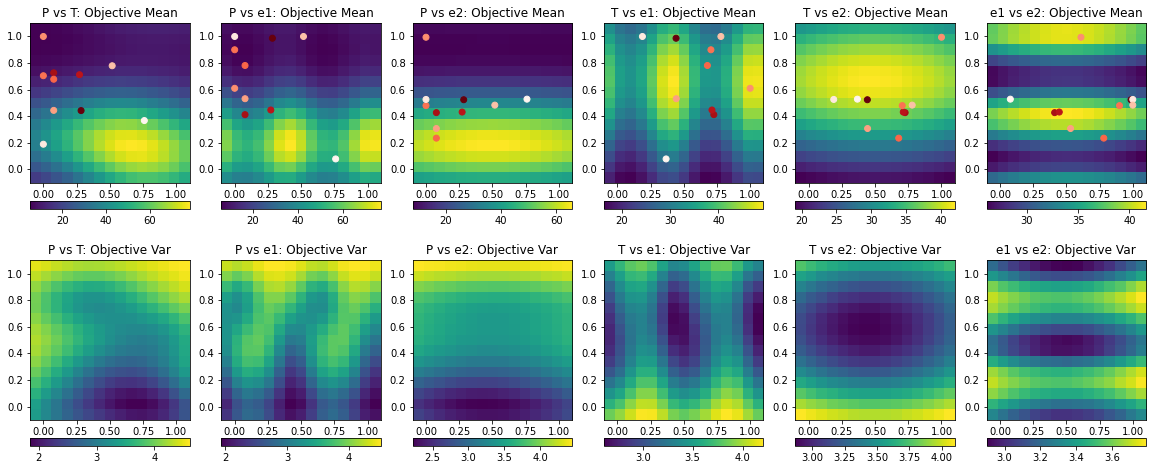

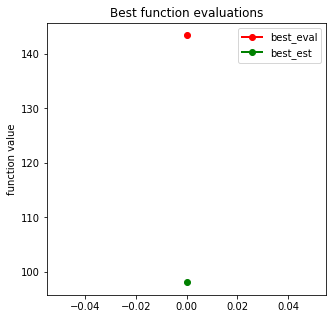

Next sample
tensor([[142.8571, 388.5714,  60.7143,  49.2857]])


In [110]:
#GP training
gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y)

#Posterior computation
y_pred_means, y_pred_vars = cal_posterior(gp_surro, test_X_norm, X, norm = "True")
y_pred_means_mat, y_pred_means_mesh = y_pred_means[0], y_pred_means[1]
y_pred_vars_mat, y_pred_vars_mesh = y_pred_vars[0], y_pred_vars[1]

# Plot current state\
#For 1st run, best_eval= None, best_est= None, is_first = True, for later iterations best_eval= best_eval, best_est= best_est, is_first = False
best_eval, best_est =visualize_state(train_X, train_X_norm, train_Y, \
                                     test_X, test_X_norm, y_pred_means, \
                                     y_pred_vars, fix_params, best_eval= None, \
                                     best_est= None, is_first = "True")

#For 1st run, idx is blank, For later iterations, idx will be the array of evaluated locations
acq_cand, acq_val, EI_val = acqmanEI(y_pred_means_mat, y_pred_vars_mat, train_Y, idx)

val = acq_val
ind = np.random.choice(acq_cand) # When multiple points have same acq values
idx = np.hstack((idx, ind))
#if ((val) == 0):  # Stop for negligible expected improvement
#    print("Model converged due to sufficient learning over search space ")
#    print(val)

nextX = torch.empty((1, len(X)))
nextX_norm = torch.empty(1, len(X))
nextX[0,:] = test_X[ind, :]
nextX_norm [0, :] = test_X_norm[ind, :]


print("Next sample")
print(nextX)

#data save for checkpoints
checkpoint_BO = [nextX, nextX_norm, train_X, train_X_norm, train_Y, best_eval, best_est]
pd.DataFrame(nextX).to_csv("nextX.csv")
pd.DataFrame(train_X).to_csv("train_X.csv")
pd.DataFrame(train_Y).to_csv("train_Y.csv")
np.save("checkpoint_BO", checkpoint_BO)

Collect and augment new data - Repeat BO iteration

- Run this script multiple time for each BO iteration after loading output from experiments

In [48]:
# Load new data from experiments (Raman spectrum)
sample_file = pd.read_csv("BO Suggestion 7_Ram.csv")
reference_file = pd.read_csv("BO Suggestion 7 Raman Ref 594C_Ram.csv") 

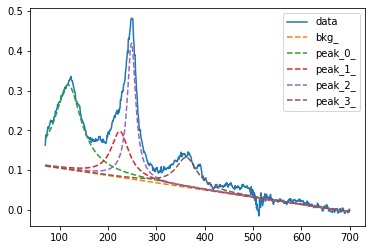

#########################################################
Current best solutions
Best params among evaluated samples:
tensor([[142.0000, 443.0000,  64.2000,  72.3000]]) tensor(143.4100, dtype=torch.float64)
Best params from GP map:
tensor([[107.1429, 571.4286,  30.7143,  69.0000]]) tensor(96.9700)


<Figure size 432x288 with 0 Axes>

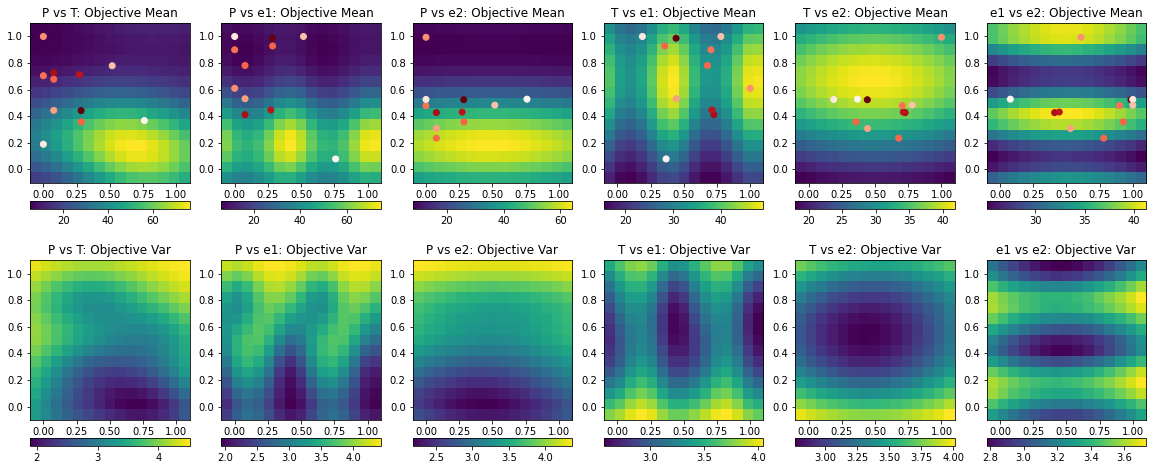

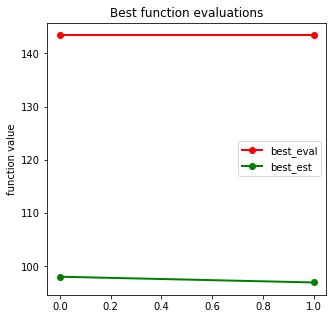

Next sample
tensor([[464.2857, 251.4286,  47.8571,  78.8571]])


/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [111]:
raman_data = [sample_file, reference_file]
# Evaluate true function for new data, augment data
train_X, train_X_norm, train_Y =\
  augment_newdata_PLD(nextX, nextX_norm, train_X, train_X_norm, train_Y, raman_data)

#GP training
gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y)

#Posterior computation
y_pred_means, y_pred_vars = cal_posterior(gp_surro, test_X_norm, X, norm = "True")
y_pred_means_mat, y_pred_means_mesh = y_pred_means[0], y_pred_means[1]
y_pred_vars_mat, y_pred_vars_mesh = y_pred_vars[0], y_pred_vars[1]

# Plot current state\
#For 1st run, best_eval= None, best_est= None, is_first = True, for later iterations best_eval= best_eval, best_est= best_est, is_first = False
best_eval, best_est =visualize_state(train_X, train_X_norm, train_Y, \
                                     test_X, test_X_norm, y_pred_means, \
                                     y_pred_vars, fix_params, best_eval= best_eval, \
                                     best_est= best_est, is_first = "False")

#For 1st run, idx is blank, For later iterations, idx will be the array of evaluated locations
acq_cand, acq_val, EI_val = acqmanEI(y_pred_means_mat, y_pred_vars_mat, train_Y, idx)

val = acq_val
ind = np.random.choice(acq_cand) # When multiple points have same acq values
ind = int(ind)
idx = np.hstack((idx, ind))

#if ((val) == 0):  # Stop for negligible expected improvement
#    print("Model converged due to sufficient learning over search space ")
#    print(val)

nextX = torch.empty((1, len(X)))
nextX_norm = torch.empty(1, len(X))
nextX[0,:] = test_X[ind, :]
nextX_norm [0, :] = test_X_norm[ind, :]
print("Next sample")
print(nextX)

#data save for checkpoints
checkpoint_BO = [nextX, nextX_norm, train_X, train_X_norm, train_Y]
pd.DataFrame(nextX).to_csv("nextX.csv")
pd.DataFrame(train_X).to_csv("train_X.csv")
pd.DataFrame(train_Y).to_csv("train_Y.csv")
np.save("checkpoint_BO", checkpoint_BO)